<a href="https://colab.research.google.com/github/Emmanuel-kabu/weather_analysis/blob/main/weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In This notebook we will build a weather prediction model using normal, **Statistical Model**, **RNN**, and **Transformers** using the **GLOBAL** **WEATHER DATASET**. We will also perform both simple and complex data analysis


# Downloading Dependencies

In [ ]:
!pip install prophet
!pip install opendatasets

#Importing all Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px
import warnings
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import itertools
import opendatasets as od
warnings.filterwarnings('ignore')

# Downloading the Dataset


In [ ]:

def download_dataset(dataset_url):
  od.download(dataset_url)
dataset = download_dataset("https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: emmanuelkabu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository


100%|██████████| 4.58M/4.58M [00:00<00:00, 38.9MB/s]

In [ ]:
import os
os.listdir(dataset)

['.config', 'global-weather-repository', 'sample_data']

In [ ]:
import pandas as pd
weather_dataset = pd.read_csv("/content/global-weather-repository/GlobalWeatherRepository.csv")

In [ ]:
weather_dataset.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [ ]:


weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58658 entries, 0 to 58657
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       58658 non-null  object 
 1   location_name                 58658 non-null  object 
 2   latitude                      58658 non-null  float64
 3   longitude                     58658 non-null  float64
 4   timezone                      58658 non-null  object 
 5   last_updated_epoch            58658 non-null  int64  
 6   last_updated                  58658 non-null  object 
 7   temperature_celsius           58658 non-null  float64
 8   temperature_fahrenheit        58658 non-null  float64
 9   condition_text                58658 non-null  object 
 10  wind_mph                      58658 non-null  float64
 11  wind_kph                      58658 non-null  float64
 12  wind_degree                   58658 non-null  int64  
 13  w

In [ ]:
weather_dataset.describe()

,latitude,longitude,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,...,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination
count,58658.000000,58658.000000,5.865800e+04,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000,...,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000,58658.000000
mean,19.136952,22.185773,1.728921e+09,22.215943,71.990315,8.280903,13.330749,169.252054,1014.127007,29.946562,...,19.133827,528.075251,63.462292,15.041631,11.393159,25.411540,50.951734,1.722289,2.698183,49.342613
std,24.476343,65.812433,7.579121e+06,9.632845,17.338930,9.300048,14.965257,103.656987,13.672152,0.403718,...,16.804654,949.111215,36.393267,26.396926,49.132283,44.893294,157.469982,0.992789,2.593229,35.004906
min,-41.300000,-175.200000,1.715849e+09,-24.900000,-12.800000,2.200000,3.600000,1.000000,947.000000,27.960000,...,3.600000,-9999.000000,0.000000,0.000000,-9999.000000,0.185000,-1848.150000,1.000000,1.000000,0.000000
25%,3.750000,-6.836100,1.722428e+09,17.000000,62.600000,4.000000,6.500000,80.000000,1010.000000,29.830000,...,10.800000,225.700000,39.000000,0.925000,0.740000,5.550000,8.695000,1.000000,1.000000,15.000000
50%,17.250000,23.320000,1.728985e+09,25.000000,77.000000,6.900000,11.200000,160.000000,1013.000000,29.920000,...,16.600000,325.600000,60.100000,3.330000,2.220000,13.505000,20.535000,1.000000,2.000000,49.000000
75%,40.400000,50.580000,1.735467e+09,28.500000,83.200000,11.400000,18.400000,257.000000,1018.000000,30.050000,...,25.500000,505.050000,83.000000,16.465000,8.880000,29.600000,45.510000,2.000000,3.000000,83.000000
max,64.150000,179.220000,1.741946e+09,49.200000,120.600000,1841.200000,2963.200000,360.000000,3006.000000,88.770000,...,2970.400000,38879.398000,480.700000,427.700000,521.330000,1614.100000,6037.290000,6.000000,10.000000,100.000000


In [ ]:
weather_dataset.tail()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
58653,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1741945500,2025-03-14 05:45,22.2,72.0,Clear,...,14.615,18.870,1,2,06:35 AM,06:38 PM,07:05 PM,06:44 AM,Full Moon,100
58654,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1741945500,2025-03-14 16:45,27.0,80.6,Partly cloudy,...,61.605,65.305,3,8,06:06 AM,06:06 PM,06:11 PM,06:00 AM,Full Moon,100
58655,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1741945500,2025-03-14 12:45,21.9,71.5,Sunny,...,29.785,116.365,2,3,06:11 AM,06:13 PM,06:26 PM,06:10 AM,Full Moon,100
58656,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1741945500,2025-03-14 11:45,23.1,73.6,Patchy rain nearby,...,11.840,12.025,1,1,06:10 AM,06:22 PM,06:33 PM,06:08 AM,Full Moon,100
58657,Zimbabwe,Harare,-17.8178,31.0447,Africa/Harare,1741945500,2025-03-14 11:45,24.2,75.6,Sunny,...,9.250,10.545,1,1,05:58 AM,06:11 PM,06:21 PM,05:56 AM,Full Moon,100


# Handling Missing Values

In [ ]:
def data_cleaning(dataset):

    # Remove leading/trailing whitespace in column names
    dataset.columns = dataset.columns.str.strip().str.lower()

    # Drop duplicate rows
    dataset.drop_duplicates(inplace=True)

    # Handle missing values intelligently
    dataset.interpolate(method='linear', inplace=True) # Interpolate missing values
    dataset.ffill(inplace=True)   # Forward fill missing values
    dataset.bfill(inplace=True)   # Backward fill missing values

    return dataset

# Apply cleaning
cleaned_weather_dataset = data_cleaning(weather_dataset)


In [ ]:
cleaned_weather_dataset[:4]

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_pm2.5,air_quality_pm10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55


In [ ]:
cleaned_weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58658 entries, 0 to 58657
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       58658 non-null  object 
 1   location_name                 58658 non-null  object 
 2   latitude                      58658 non-null  float64
 3   longitude                     58658 non-null  float64
 4   timezone                      58658 non-null  object 
 5   last_updated_epoch            58658 non-null  int64  
 6   last_updated                  58658 non-null  object 
 7   temperature_celsius           58658 non-null  float64
 8   temperature_fahrenheit        58658 non-null  float64
 9   condition_text                58658 non-null  object 
 10  wind_mph                      58658 non-null  float64
 11  wind_kph                      58658 non-null  float64
 12  wind_degree                   58658 non-null  int64  
 13  w

#Handling Outliers

In [ ]:
def handle_outliers(dataset):
    iso = IsolationForest(contamination=0.01, random_state=42)
    outliers = iso.fit_predict(dataset.select_dtypes(include=[np.number]))
    # droping outlier column for further model training
    dataset['outlier'] = outliers
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers) / len(dataset) * 100:.2f}%")
    print(f"Outliers:\n{outliers}")
    cleaned_dataset = dataset[dataset["outlier"] != -1].drop(columns=["outlier"])

    return cleaned_dataset

outlier_free_dataset =handle_outliers(cleaned_weather_dataset)

Number of outliers: 58658
Percentage of outliers: 100.00%
Outliers:
[1 1 1 ... 1 1 1]


In [ ]:
print(outlier_free_dataset.columns)

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_carbon_monoxide',
       'air_quality_ozone', 'air_quality_nitrogen_dioxide',
       'air_quality_sulphur_dioxide', 'air_quality_pm2.5', 'air_quality_pm10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')


# Visualizing the outliers

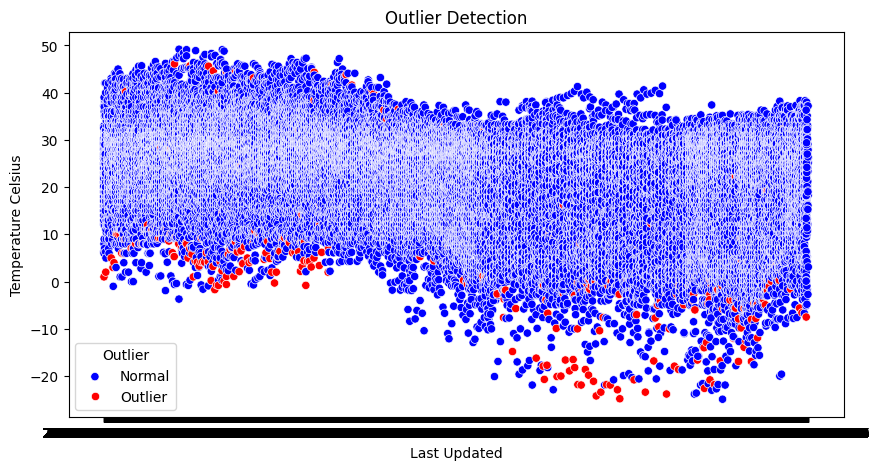

In [ ]:



def plot_outliers(data, x_col, y_col, outlier_col='outlier', title='Outlier Detection'):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=data, x=x_col, y=y_col, hue=outlier_col, palette={1: 'blue', -1: 'red'})
    plt.title(title)
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(y_col.replace('_', ' ').title())
    plt.legend(title="Outlier", labels=["Normal", "Outlier"])
    plt.show()
plot_outliers(cleaned_weather_dataset, x_col='last_updated', y_col='temperature_celsius')


In [ ]:
outlier_free_dataset['last_updated']

,last_updated
0,2024-05-16 13:15
1,2024-05-16 10:45
2,2024-05-16 09:45
3,2024-05-16 10:45
4,2024-05-16 09:45
...,...
58653,2025-03-14 05:45
58654,2025-03-14 16:45
58655,2025-03-14 12:45
58656,2025-03-14 11:45


# Performing EDA


Correlation between numerical values

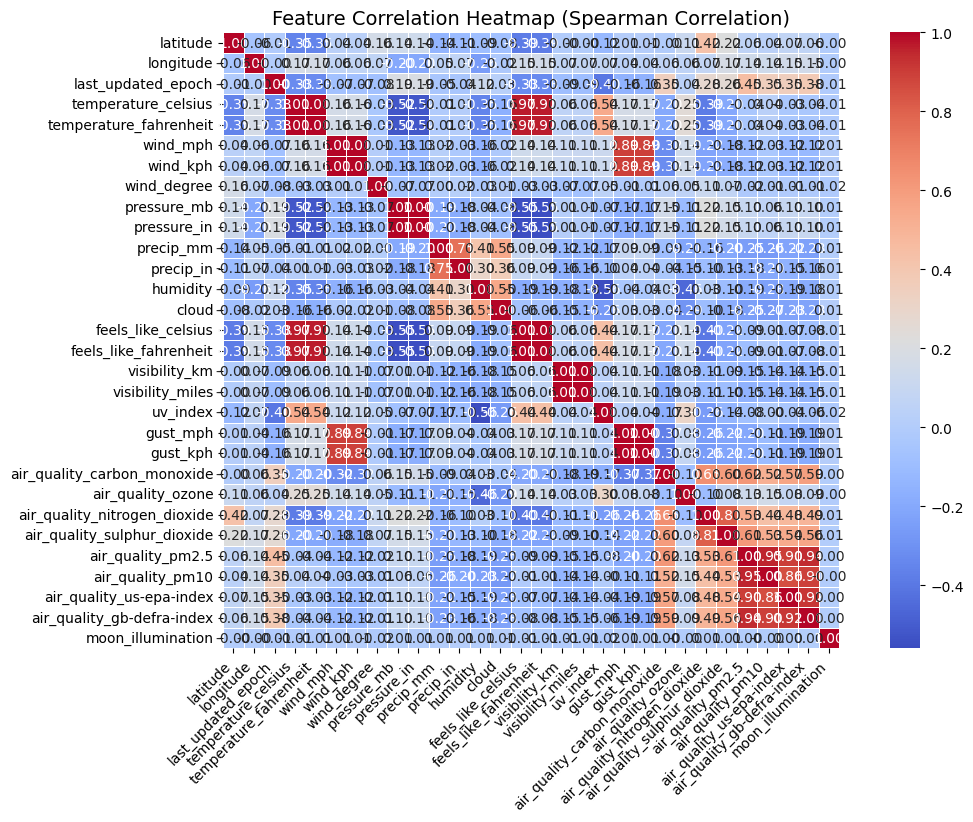

In [ ]:

def numeric_correlation(dataset, method="pearson"):
 # selecting only numeric features
    numeric_df = dataset.select_dtypes(include=[np.number])

    # Check if there are numeric columns
    if numeric_df.empty:
        print("No numeric columns found in the dataset.")
        return

    # Compute correlation matrix
    corr_matrix = numeric_df.corr(method=method)

    # Plot heatmap
    plt.figure(figsize=(13, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)

    plt.title(f'Feature Correlation Heatmap ({method.title()} Correlation)', fontsize=14)
    plt.xticks(rotation=45, ha="right")  # improve plot visibility
    plt.yticks(rotation=0)
    plt.show()

numeric_correlation(outlier_free_dataset, method="spearman")


# Temperature trend by country

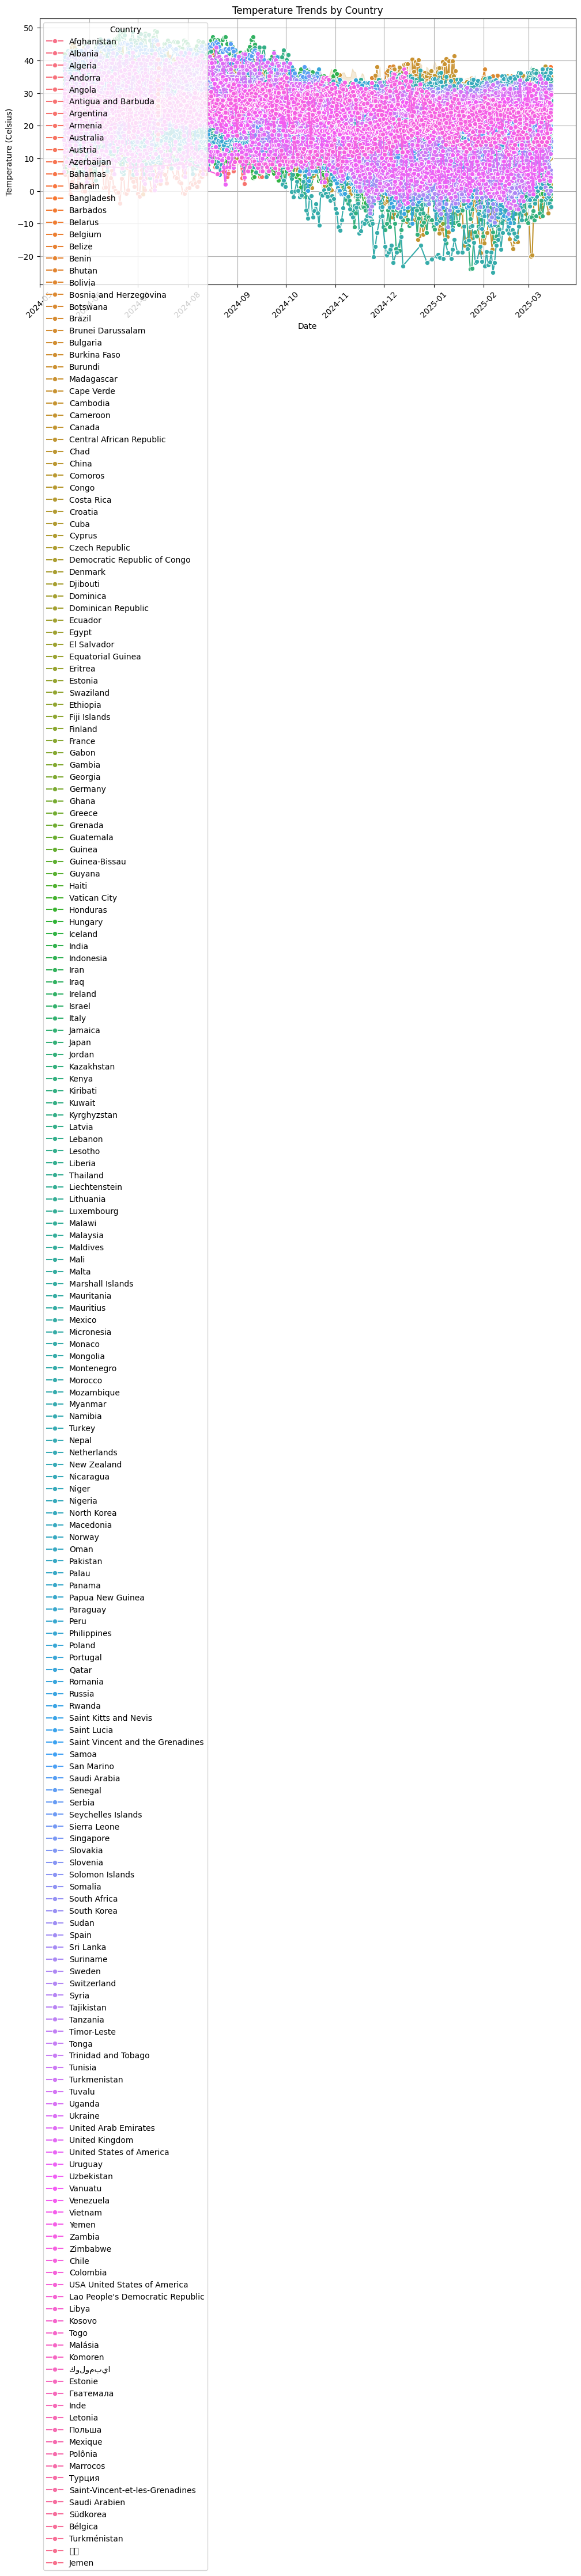

In [ ]:
def plot_temperature_trends_by_country(df, date_col='last_updated', temp_col='temperature_celsius', country_col='country'):

    # Ensure the dataset contains the necessary columns
    if country_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])  # Convert date column to datetime format

        plt.figure(figsize=(12,6))
        sns.lineplot(data=df, x=date_col, y=temp_col, hue=country_col, marker="o")

        plt.title('Temperature Trends by Country')
        plt.xlabel('Date')
        plt.ylabel('Temperature (Celsius)')
        plt.legend(title="Country")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    else:
        print(f"Column '{country_col}' not found in dataset. Skipping plot.")

# Example Usage:
plot_temperature_trends_by_country(df=outlier_free_dataset)




Spatial Analysis

In [ ]:
def plot_spatial_temperature_distribution(df, lat_col='latitude', lon_col='longitude', temp_col='temperature_celsius'):

    # Ensure the dataset contains the necessary columns
    if lat_col in df.columns and lon_col in df.columns:
        fig = px.scatter_geo(df, lat=lat_col, lon=lon_col, color=temp_col,
                             title='Global Temperature Distribution',
                             color_continuous_scale='plasma',
                             projection="natural earth")
        fig.update_layout(geo=dict(showcoastlines=True))
        fig.show()
    else:
        print(f"Columns '{lat_col}' or '{lon_col}' not found in dataset. Skipping plot.")

# Example Usage:
plot_spatial_temperature_distribution(df=outlier_free_dataset)

In [ ]:
print(outlier_free_dataset.columns)

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_carbon_monoxide',
       'air_quality_ozone', 'air_quality_nitrogen_dioxide',
       'air_quality_sulphur_dioxide', 'air_quality_pm2.5', 'air_quality_pm10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')


#preprocessing the Target feature

In [ ]:
def preprocess_target(target_series, normalize=True, resample_data=True, resample_freq='D', method='mean'):
    outlier_free_dataset['last_updated'] = pd.to_datetime(outlier_free_dataset['last_updated'])
    target_series.index = outlier_free_dataset['last_updated']
    target = target_series.astype(np.float32)  # Convert to float32 to save memory

    # Normalize target (Min-Max Scaling)
    if normalize:
        target_min, target_max = target.min(), target.max()
        target = (target - target_min) / (target_max - target_min)

    # Resample target data if needed
    if resample_data:
        if resample_freq not in ['H','D', 'M', 'Y']:
            raise ValueError("Invalid resample_freq. Choose from 'D' (daily), 'M' (monthly), or 'Y' (yearly).")

        if method == 'mean':
            target = target.resample(resample_freq).mean()
        elif method == 'median':
            target = target.resample(resample_freq).median()
        elif method == 'sum':
            target = target.resample(resample_freq).sum()
        else:
            raise ValueError("Invalid method. Choose from 'mean', 'median', or 'sum'.")

    return target
target_features = outlier_free_dataset['temperature_celsius']
processed_target = preprocess_target(target_features, resample_freq='M')



In [ ]:
processed_target

,temperature_celsius
last_updated,
2024-05-31,0.676520
2024-06-30,0.694186
2024-07-31,0.699070
2024-08-31,0.698861
2024-09-30,0.675060
2024-10-31,0.637458
2024-11-30,0.598734
2024-12-31,0.579649
2025-01-31,0.574299


#Building ARIMA MODEL

ARIMA(0, 0, 0) RMSE=0.073
ARIMA(0, 0, 1) RMSE=0.037
ARIMA(0, 0, 2) RMSE=0.032
ARIMA(0, 0, 3) RMSE=0.034
ARIMA(0, 1, 0) RMSE=0.018
ARIMA(0, 1, 1) RMSE=0.012
ARIMA(0, 1, 2) RMSE=0.010
ARIMA(0, 1, 3) RMSE=0.016
ARIMA(0, 2, 0) RMSE=0.014
ARIMA(0, 2, 1) RMSE=0.012
ARIMA(0, 2, 2) RMSE=0.013
ARIMA(0, 2, 3) RMSE=0.014
ARIMA(1, 0, 0) RMSE=0.026
ARIMA(1, 0, 1) RMSE=0.015
ARIMA(1, 0, 2) RMSE=0.020
ARIMA(1, 0, 3) RMSE=0.022
ARIMA(1, 1, 0) RMSE=0.013
ARIMA(1, 1, 1) RMSE=0.017
ARIMA(1, 1, 2) RMSE=0.010
ARIMA(1, 1, 3) RMSE=0.015
ARIMA(1, 2, 0) RMSE=0.012
ARIMA(1, 2, 1) RMSE=0.014
ARIMA(1, 2, 2) RMSE=0.015
ARIMA(1, 2, 3) RMSE=0.014
ARIMA(2, 0, 0) RMSE=0.011
ARIMA(2, 0, 1) RMSE=0.009
ARIMA(2, 0, 2) RMSE=0.014
ARIMA(2, 0, 3) RMSE=0.013
ARIMA(2, 1, 0) RMSE=0.011
ARIMA(2, 1, 1) RMSE=0.012
ARIMA(2, 1, 2) RMSE=0.017
ARIMA(2, 1, 3) RMSE=0.016
ARIMA(2, 2, 0) RMSE=0.014
ARIMA(2, 2, 1) RMSE=0.013
ARIMA(2, 2, 2) RMSE=0.016
ARIMA(2, 2, 3) RMSE=0.018
ARIMA(3, 0, 0) RMSE=0.010
ARIMA(3, 0, 1) RMSE=0.012
ARIMA(3, 0, 

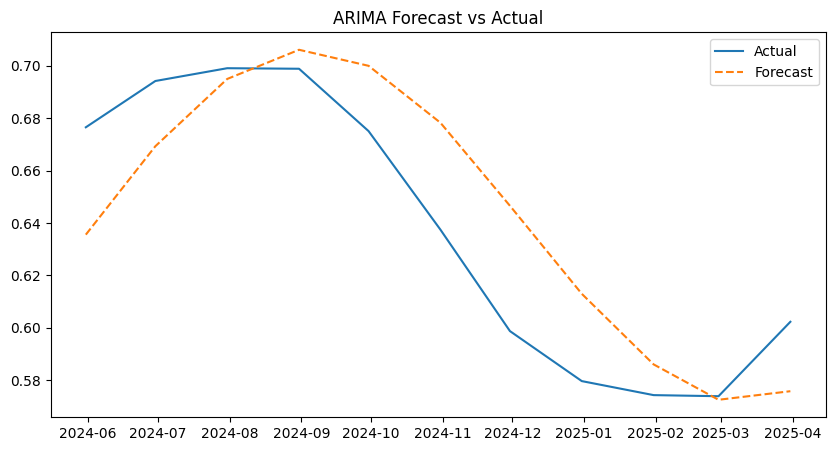

In [ ]:
# finding the best (p, d, q) using Rolling Cross-Validation
def find_best_arima(train_data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            errors = []
            tscv = TimeSeriesSplit(n_splits=5)  # Rolling Window Cross-Validation

            for train_idx, test_idx in tscv.split(train_data):
                train, test = train_data.iloc[train_idx], train_data.iloc[test_idx]
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                predictions = model_fit.forecast(steps=len(test))
                rmse = sqrt(mean_squared_error(test, predictions))
                errors.append(rmse)

            avg_rmse = np.mean(errors)
            if avg_rmse < best_score:
                best_score, best_cfg = avg_rmse, (p, d, q)
            print(f'ARIMA{(p,d,q)} RMSE={avg_rmse:.3f}')
        except:
            continue
    print(f'Best ARIMA model: {best_cfg} with RMSE={best_score:.3f}')
    return best_cfg


# Load your target feature (make sure it's a time series with datetime index)
target_series = preprocess_target(target_features, resample_data=True, resample_freq='M')

# Split data (80% training, 20% testing)
#train_size = int(len(target_series) * 0.8)
#train, test = target_series[:train_size], target_series[train_size:]

# Find the best ARIMA parameters
p_values = range(0, 4)   # AR terms
d_values = range(0, 3)   # Differencing terms
q_values = range(0, 4)   # MA terms
best_p, best_d, best_q = find_best_arima(target_series, p_values, d_values, q_values)

# Train ARIMA model with best parameters
model = ARIMA(target_series, order=(best_p, best_d, best_q))
model_fit = model.fit()

# Forecast
arima_forecast = model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=target_series.index[-1], periods=12, freq='M')
#arima_forecast = model_fit.forecast(steps=len(test))

available_length = min(len(target_series), 12)
arima_pred = arima_forecast.predicted_mean[:available_length]
actual = target_series[-available_length:]
# Evaluate model performance
arima_rmse = sqrt(mean_squared_error(actual, arima_pred))
arima_mae = mean_absolute_error(actual, arima_pred)
print(f'Final Test RMSE: {arima_rmse:.3f}')
print(f'Final Test MAE: {arima_mae:.3f}')

# Plot actual vs. forecasted values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(actual.index, actual, label="Actual")
plt.plot(actual.index, arima_pred, label="Forecast", linestyle="dashed")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


In [ ]:
print(arima_pred)

2025-04-30    0.635545
2025-05-31    0.669289
2025-06-30    0.694962
2025-07-31    0.706104
2025-08-31    0.699983
2025-09-30    0.678263
2025-10-31    0.646555
2025-11-30    0.612965
2025-12-31    0.586024
2026-01-31    0.572521
2026-02-28    0.575795
Freq: ME, Name: predicted_mean, dtype: float64


In [ ]:
print(actual)

last_updated
2024-05-31    0.676520
2024-06-30    0.694186
2024-07-31    0.699070
2024-08-31    0.698861
2024-09-30    0.675060
2024-10-31    0.637458
2024-11-30    0.598734
2024-12-31    0.579649
2025-01-31    0.574299
2025-02-28    0.573881
2025-03-31    0.602289
Freq: ME, Name: temperature_celsius, dtype: float32


#Building Prophet model

In [ ]:
print(outlier_free_dataset.columns)

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_carbon_monoxide',
       'air_quality_ozone', 'air_quality_nitrogen_dioxide',
       'air_quality_sulphur_dioxide', 'air_quality_pm2.5', 'air_quality_pm10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lvcq_0i/kog7m8w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lvcq_0i/512bvmej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7334', 'data', 'file=/tmp/tmp6lvcq_0i/kog7m8w6.json', 'init=/tmp/tmp6lvcq_0i/512bvmej.json', 'output', 'file=/tmp/tmp6lvcq_0i/prophet_modelhpqxsfmb/prophet_model-20250315013045.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:30:45 - cmdstanpy - INFO - Chain [1] start processing
INF

[0.55825698 0.5577964  0.55733581 0.55687523 0.55641465 0.55595406
 0.55549348 0.5550329  0.55457231 0.55411173 0.55365114]
MSE: 0.009
RMSE: 0.095
MAE: 0.081


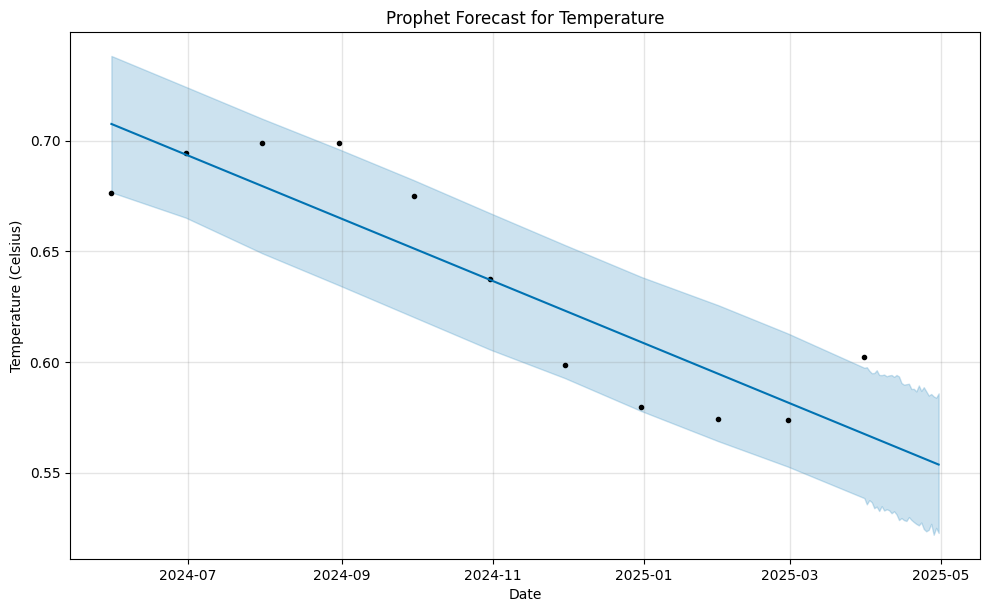

In [ ]:
#Preprocessing the data
target_series = preprocess_target(target_features,resample_freq='M')

# Prophet Training
def train_prophet(df, forecast_period=30):

    # Ensure 'ds' column is datetime
    #['ds'] = pd.to_datetime(df['ds'])
    target_series = preprocess_target(target_features,resample_freq='M')
    target_series = target_series.reset_index() # Reset index to make 'last_updated' a column
    target_series = target_series.rename(columns={"last_updated": "ds", "temperature_celsius": "y"}) # Rename columns


    # Initialize Prophet model
    model = Prophet()

    # Train-test split (80% train, 20% test)
    #train_size = int(len(target_series) * 0.8)  # Changed to target_series
    #train, test = target_series.iloc[:train_size], target_series.iloc[train_size:]  # Changed to target_series

    # Fit the model
    model.fit(target_series) # Changed to train the model on train data

    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_period, freq='D')

    # Forecast
    forecast = model.predict(future)

    #  predict values for evaluation
    forecast_values = forecast['yhat'][-available_length:].values
    print(forecast_values)


    # Calculate error
    mse = mean_squared_error(actual, forecast_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, forecast_values)

    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')

    # Visualization
    fig = model.plot(forecast)
    plt.title('Prophet Forecast for Temperature')
    plt.xlabel('Date')
    plt.ylabel('Temperature (Celsius)')
    plt.show()

    """
    plt.figure(figsize=(12, 6))
    plt.plot(target_series['ds'], target_series['y'], label='Actual', color='blue') # Changed to target_series
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red', linestyle='dashed')
    plt.axvline(x=target_series['ds'][train_size], color='black', linestyle='--', label="Train-Test Split") # Changed to target_series
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Prophet Forecast vs Actual')
    plt.legend()
    plt.show()
    """
    return model, forecast_values

model,  forecast_values= train_prophet(target_series, forecast_period=30)

#Building The Esemble model


Ensemble Model Evaluation:
Ensemble MAE: 0.0388
Ensemble RMSE: 0.0494


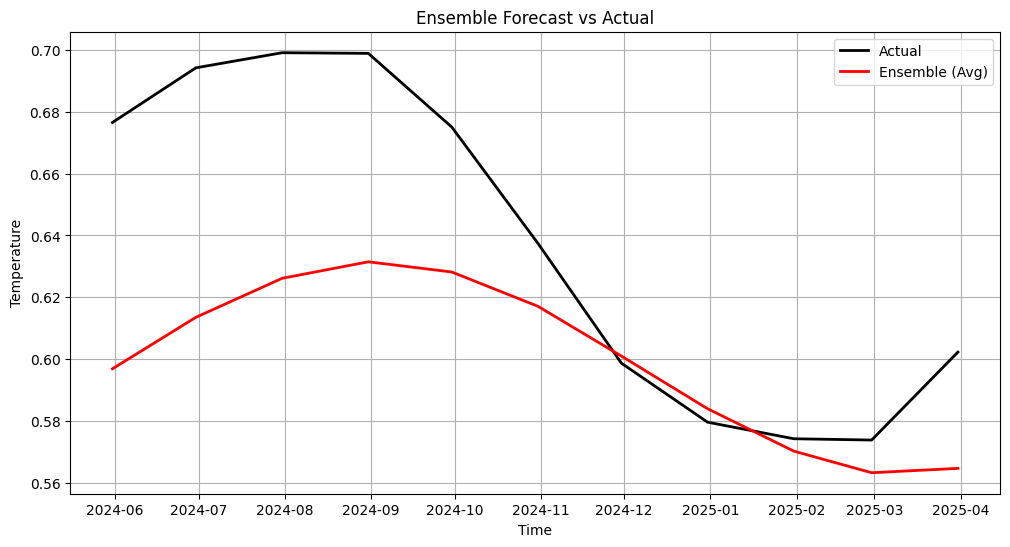

(2025-04-30    0.596901
 2025-05-31    0.613543
 2025-06-30    0.626149
 2025-07-31    0.631489
 2025-08-31    0.628199
 2025-09-30    0.617109
 2025-10-31    0.601024
 2025-11-30    0.583999
 2025-12-31    0.570298
 2026-01-31    0.563317
 2026-02-28    0.564723
 Freq: ME, Name: predicted_mean, dtype: float64,
 0.03877619129453014,
 0.04942584152343181)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

def ensemble_predict(actual, *predictions):
  # Converting NumPy arrays to pandas series
    predictions = [pd.Series(pred, index=actual.index) if isinstance(pred, np.ndarray) else pred for pred in predictions]
    # Convert predictions into a DataFrame
    predictions_df = pd.concat(predictions, axis=1)

    # Ensure index alignment with actual values
    predictions_df = predictions_df.loc[actual.index]

    # Compute simple average for ensemble prediction
    #ensemble_pred = predictions_df.mean(axis=1)
    ensemble_pred = (arima_pred + forecast_values)/2

    # Compute errors
    ensemble_mae = mean_absolute_error(actual, ensemble_pred)
    ensemble_rmse = np.sqrt(mean_squared_error(actual, ensemble_pred))

    # Print evaluation results
    print("\nEnsemble Model Evaluation:")
    print(f"Ensemble MAE: {ensemble_mae:.4f}")
    print(f"Ensemble RMSE: {ensemble_rmse:.4f}")

    # Plot actual vs predictions
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label="Actual", color='black', linewidth=2)
    #for i, pred in enumerate(predictions):
      #  plt.plot(actual.index, pred, linestyle='dashed', label=f"Model {i+1}")
    plt.plot(actual.index, ensemble_pred, label="Ensemble (Avg)", color='red', linewidth=2)

    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.title("Ensemble Forecast vs Actual")
    plt.legend()
    plt.grid()
    plt.show()

    return ensemble_pred, ensemble_mae, ensemble_rmse
ensemble_predict(actual,  arima_pred, forecast_values)

In [ ]:
print(actual)

last_updated
2024-05-31    0.676520
2024-06-30    0.694186
2024-07-31    0.699070
2024-08-31    0.698861
2024-09-30    0.675060
2024-10-31    0.637458
2024-11-30    0.598734
2024-12-31    0.579649
2025-01-31    0.574299
2025-02-28    0.573881
2025-03-31    0.602289
Freq: ME, Name: temperature_celsius, dtype: float32


#Building a Prophet weather forecast model for seasonality and trend

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lvcq_0i/ox0h2mrm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lvcq_0i/gyccidd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3962', 'data', 'file=/tmp/tmp6lvcq_0i/ox0h2mrm.json', 'init=/tmp/tmp6lvcq_0i/gyccidd5.json', 'output', 'file=/tmp/tmp6lvcq_0i/prophet_model8tn6kr3w/prophet_model-20250314223818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:38:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


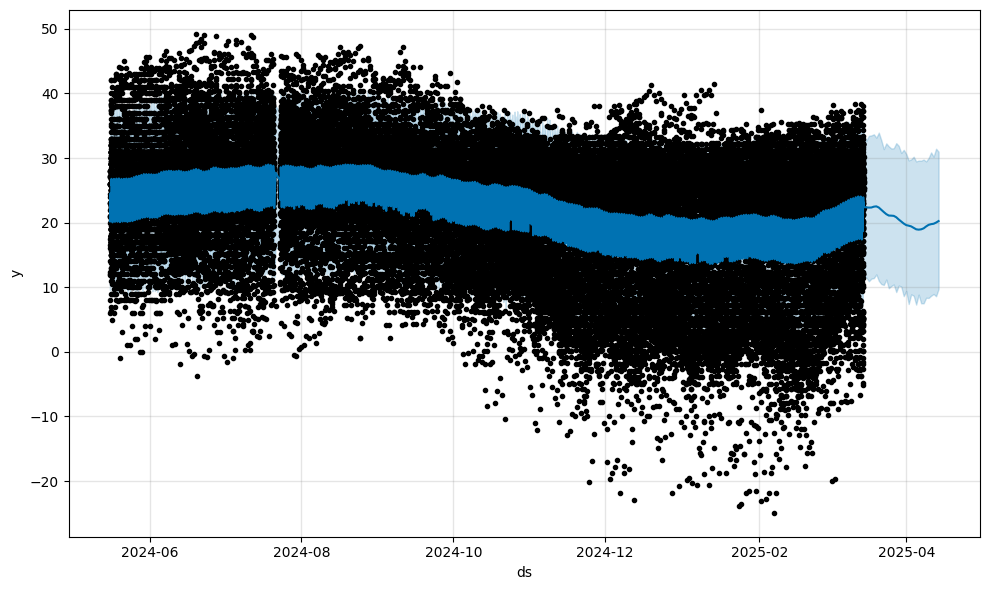

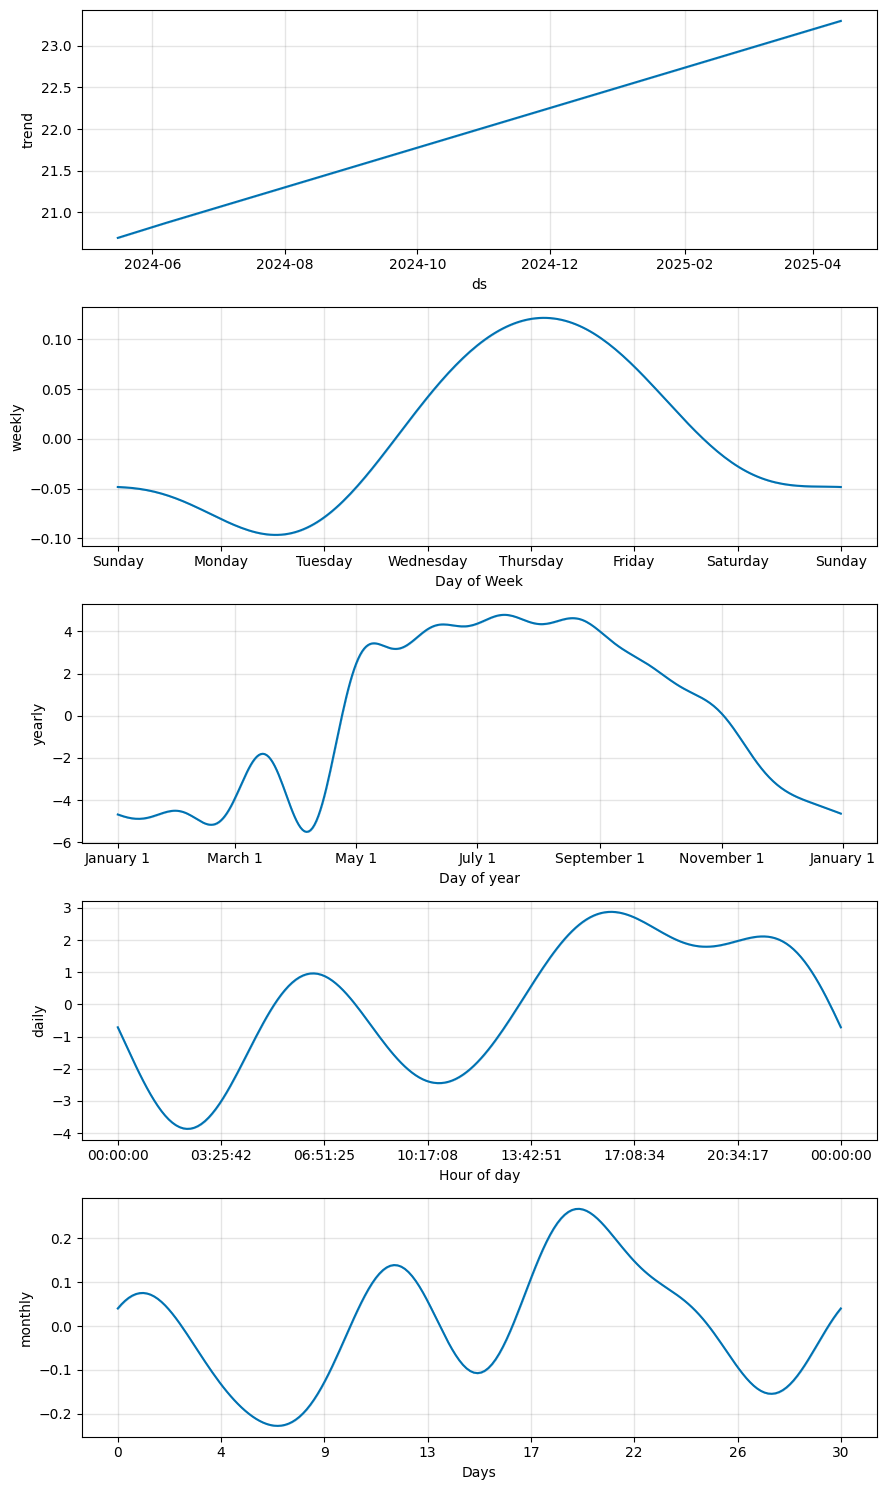

In [ ]:
# Ensure date column is in datetime format
outlier_free_dataset["last_updated"] = pd.to_datetime(outlier_free_dataset["last_updated"])

# Rename columns to fit Prophet's requirements
weather= outlier_free_dataset.rename(columns={"last_updated": "ds", "temperature_celsius": "y"})

# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)  # Custom seasonality
model.fit(weather)

# Create a future dataframe (predict next 365 days)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.show()

# Plot the components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()


In [ ]:
print(forecast)

                      ds      trend  yhat_lower  yhat_upper  trend_lower  \
0    2024-05-16 01:45:00  20.694553    9.141072   31.168062    20.694553   
1    2024-05-16 02:45:00  20.694893   10.014375   31.575443    20.694893   
2    2024-05-16 03:45:00  20.695234   10.810995   33.372191    20.695234   
3    2024-05-16 04:45:00  20.695574   13.099986   34.319769    20.695574   
4    2024-05-16 05:45:00  20.695914   13.536527   35.584110    20.695914   
...                  ...        ...         ...         ...          ...   
9805 2025-04-09 22:45:00  23.268184    8.744595   30.366204    23.267773   
9806 2025-04-10 22:45:00  23.275989    9.018613   31.242091    23.275559   
9807 2025-04-11 22:45:00  23.283794    9.362825   31.253446    23.283333   
9808 2025-04-12 22:45:00  23.291599    9.708240   31.454506    23.291106   
9809 2025-04-13 22:45:00  23.299404    9.322857   30.419794    23.298885   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     

#Feature importance selection

In [ ]:
from sklearn.feature_selection import mutual_info_regression, RFE
from xgboost import XGBRegressor
import shap

def select_important_features(df, target, top_n=15):

    # Drop target from features
    X = df.drop(columns=[target])
    y = df[target]

   # Step 2: Select features highly correlated with the target


    corr_matrix = outlier_free_dataset.select_dtypes(include=[np.number]).corr()
    target_corr_threshold = 0.8

    target_corr = corr_matrix[target].abs()
    selected_features = target_corr[target_corr > target_corr_threshold].index.tolist()

    # Remove Highly Correlated Features (Threshold > 0.80)
    Corr_matrix = corr_matrix.abs()
    upper_tri = Corr_matrix.where(np.triu(np.ones(Corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.80)]
    X = X.drop(columns=to_drop)

    #
    mi_scores = mutual_info_regression(X, y)
    mi_features = pd.Series(mi_scores, index=X.columns).nlargest(top_n).index.tolist()

    # Recursive Feature Elimination (RFE) with XGBoost
    xgb = XGBRegressor(n_estimators=100, random_state=42)
    rfe = RFE(xgb, n_features_to_select=top_n)
    rfe.fit(X, y)
    rfe_features = X.columns[rfe.support_].tolist()

    # XGBoost Feature Importance
    xgb.fit(X, y)
    xgb_features = pd.Series(xgb.feature_importances_, index=X.columns).nlargest(top_n).index.tolist()

    #SHAP Feature Importance
    explainer = shap.Explainer(xgb)
    shap_values = explainer(X)
    shap_importance = np.abs(shap_values.values).mean(axis=0)
    shap_features = pd.Series(shap_importance, index=X.columns).nlargest(top_n).index.tolist()

    # Combine Feature Lists & Select Most Frequent
    all_selected = mi_features + rfe_features + xgb_features + shap_features
    selected_features = pd.Series(all_selected).value_counts().index[:top_n].tolist()

    # Return DataFrame with selected features
    df_selected = df[selected_features + [target]]

    return selected_features, df_selected

numeric_df= outlier_free_dataset.select_dtypes(include=[np.number])
selected_features, df_selected = select_important_features(numeric_df, target="temperature_celsius", top_n=15)

print(" Top selected features:", selected_features)
print("New dataset shape:", df_selected.shape)

 Top selected features: ['latitude', 'air_quality_nitrogen_dioxide', 'air_quality_pm10', 'longitude', 'cloud', 'air_quality_carbon_monoxide', 'last_updated_epoch', 'pressure_mb', 'uv_index', 'humidity', 'air_quality_sulphur_dioxide', 'wind_degree', 'wind_mph', 'precip_mm', 'air_quality_pm2.5']
New dataset shape: (58071, 16)


#Visualization important features or columns

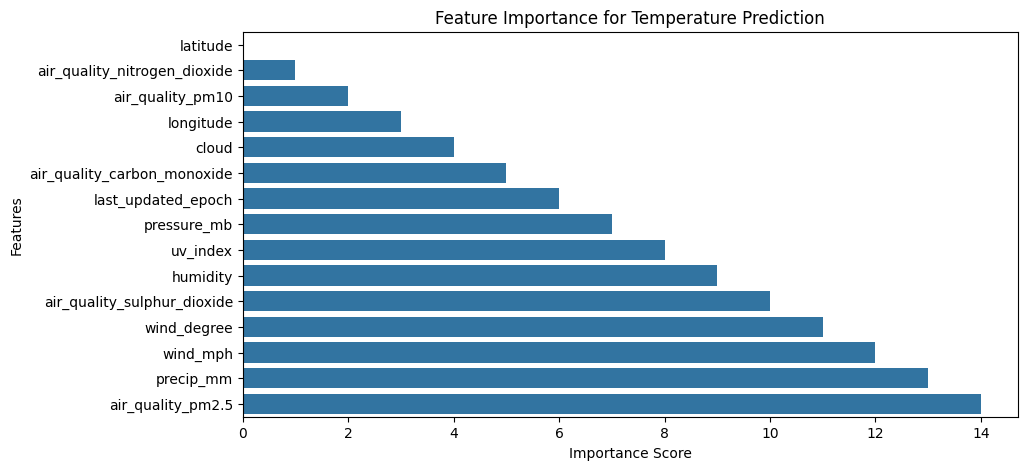

In [ ]:
def plot_feature_importance(feature_importance_df, title="Feature Importance for Temperature Prediction"):

    plt.figure(figsize=(10, 5))
    sns.barplot(selected_features )
    plt.title(title)
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

# Example usage:
plot_feature_importance(df_selected)


In [ ]:
outlier_free_dataset.columns

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_carbon_monoxide',
       'air_quality_ozone', 'air_quality_nitrogen_dioxide',
       'air_quality_sulphur_dioxide', 'air_quality_pm2.5', 'air_quality_pm10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')

In [ ]:
print(outlier_free_dataset['air_quality_pm10'])

0         26.600
1          2.000
2         18.400
3          0.900
4        262.300
          ...   
58653     18.870
58654     65.305
58655    116.365
58656     12.025
58657     10.545
Name: air_quality_pm10, Length: 58071, dtype: float64


#Environmental impact analysis

In [ ]:
def environmental_impact_analysis(df, target='temperature_celsius', features=['air_quality_pm2.5', 'air_quality_pm10']):

    selected_columns = [target] + features
    correlations = df[selected_columns].corr()

    print("\nEnvironmental Impact Analysis:")
    print(correlations)

    return correlations

# Example usage:
correlation_matrix = environmental_impact_analysis(outlier_free_dataset)



Environmental Impact Analysis:
                     temperature_celsius  air_quality_pm2.5  air_quality_pm10
temperature_celsius             1.000000          -0.017656          0.054701
air_quality_pm2.5              -0.017656           1.000000          0.681862
air_quality_pm10                0.054701           0.681862          1.000000


# Heatmap for environmental impact analysis


Environmental Impact Analysis:
                     temperature_celsius  air_quality_pm2.5  air_quality_pm10
temperature_celsius             1.000000          -0.017656          0.054701
air_quality_pm2.5              -0.017656           1.000000          0.681862
air_quality_pm10                0.054701           0.681862          1.000000


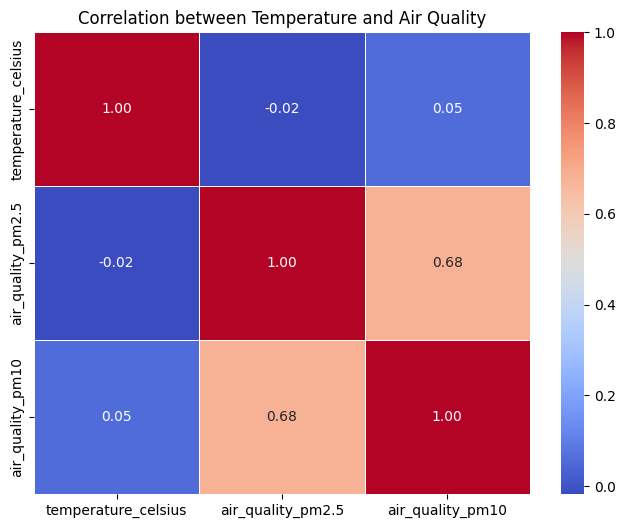

In [ ]:
def plot_correlation_heatmap(correlations, title='Correlation between Temperature and Air Quality'):

    plt.figure(figsize=(8,6))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.show()

# Example usage:
correlation_matrix = environmental_impact_analysis(outlier_free_dataset)  # Ensure you run this function first
plot_correlation_heatmap(correlation_matrix)


#Building RNN to predict multiple environmental factors

# Splitting The dataset

In [ ]:
def split_dataset(df):
        # Ensure last_updated is in datetime format
    df['last_updated'] = pd.to_datetime(df['last_updated'])

    # Define the splits
    train_df = df[(df['last_updated'] >= '2012-01-01') & (df['last_updated'] < '2014-01-01')]
    val_df = df[(df['last_updated'] >= '2014-01-01') & (df['last_updated'] < '2016-01-01')]
    test_df = df[df['last_updated'] >= '2016-01-01']

    return train_df, val_df, test_df


#train_df, val_df, test_df = split_dataset(input_features)
#For forcasting using ARIMA
train_target, val_target, test_target = split_dataset(target_features)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler